## packages and imports

In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import time
from pathlib import Path

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
num_bases = 10
num_trunk_epochs = 30000
lr = 1e-3
num_LBFGS_epochs = 100000
#t_stride = 1
eps = 1e-8 # to prevent loss overflow

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

W0000 00:00:1768402754.660448 2295868 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768402754.691012 2295868 service.cc:145] XLA service 0x1383b0360 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768402754.691040 2295868 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768402754.693465 2295868 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768402754.693475 2295868 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [2]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [3]:
# load external dataset
# NOTE we're loading t, and subsampling every t_stride steps
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n,t,x)

# disabled functionality for train/test split for now
#n_samp = len(data)
#train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.0, random_state = seed)
#u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
#s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])



grid is (t,x) =  201 201


In [4]:
u_train, s_train = u,s
print('label dataset size is (n, coord) = ', u_train.shape)
print('input dataset size is (t,x,n) = ', s_train.shape)

output_tr = jnp.transpose(s_train, axes=(1,2,0)) 
print(f"subsampled dataset size is (t,x,n) = {output_tr.shape}")

label dataset size is (n, coord) =  (441, 2)
input dataset size is (t,x,n) =  (441, 201, 201)
subsampled dataset size is (t,x,n) = (201, 201, 441)


In [5]:
s.shape

(441, 201, 201)

(201, 201) (201, 201) (201, 201)


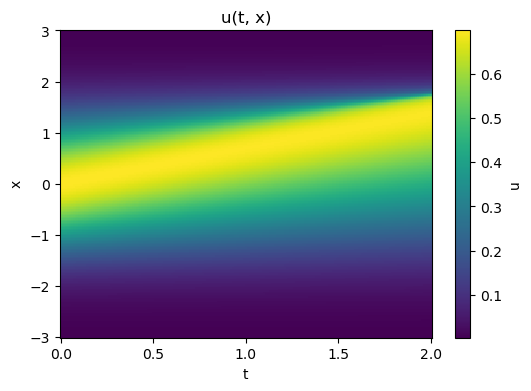

In [6]:

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")   # match sol[t,x]
print(T.shape, X.shape, output_tr[:,:,0].shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, output_tr[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("u(t, x)")
plt.colorbar(label="u")
plt.show()


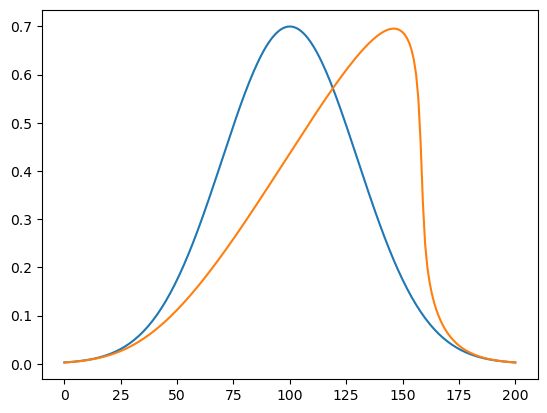

In [7]:
plt.plot(s[0,0,:])
plt.plot(s[0,-1,:])

In [8]:
tt,xx = jnp.meshgrid(t_grid, x_grid)
tx_grid = jnp.concatenate([tt.flatten()[:,None], xx.flatten()[:,None]], axis=1) #xt_grid[:,1] is x, xt_grid[:,0] is t
print("tx_grid is of shape (n, coord) = ",tx_grid.shape)

tx_grid is of shape (n, coord) =  (40401, 2)


## initializing model, loss_fn

In [9]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_bases] 
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, output_tr.shape[2])) # now A_model is a 3-tensor -- indexed as t, branch, n. as opposed to one matrix for entire xt domain
print("A_model is shape (t, num_bases, num_samples) = ", A_model.shape)

model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
    print(T_MAT.shape, A_model.shape)
    pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples
    # pred_y[i,:,:] = T_mat[i,:,:] @ A_model[i,:,:], T_mat @ A_model for each individual time, analogous to vanilla case
    return jnp.mean((output_tr - pred_y) ** 2)/jnp.mean(output_tr ** 2) + eps # rel mean squared error

A_model is shape (t, num_bases, num_samples) =  (201, 10, 441)


In [10]:
%%time
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

s_time = time.time()
start_time = time.time()
for step in range(num_trunk_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 10 == 0: # new carriage print, avoid tqdm for memory
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}, {end_time-start_time:.2f}s", end="", flush=True)
        start_time = time.time()
e_time = time.time()
print(f"\nfinal adam loss: {loss:.3e}, total time: {e_time-s_time:.2f}s\n")

## LBFGS disabled for now. rebuild to match adam
opt = optax.lbfgs()

for step in range(num_LBFGS_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss))
    if step % 100 == 0:
        print(
            f"\r{' ' * 80}\rLBFGS step {step}: loss={float(loss):.3e}",
            end="",
            flush=True
        )

(201, 201, 10) (201, 10, 441)
Adam step 29990: loss=8.880e-05, 0.15s
final adam loss: 9.834e-05, total time: 446.19s

LBFGS step 99900: loss=2.564e-05                                                CPU times: user 6min 40s, sys: 1min 34s, total: 8min 15s
Wall time: 32min 12s


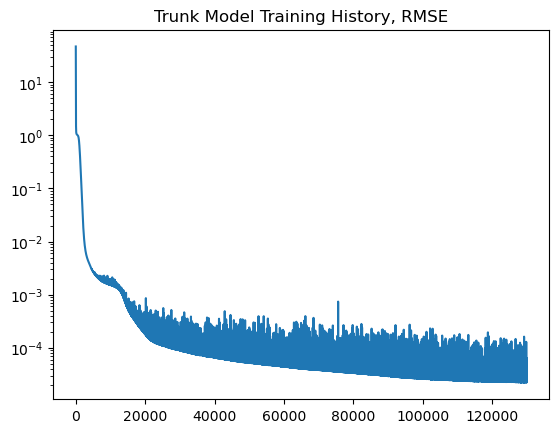

In [11]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, RMSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [12]:
trunk_model, A_model = model
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)

T_MAT is shape (t,x,n) =  (201, 201, 10)


(201, 201) (201, 201) (201, 201)


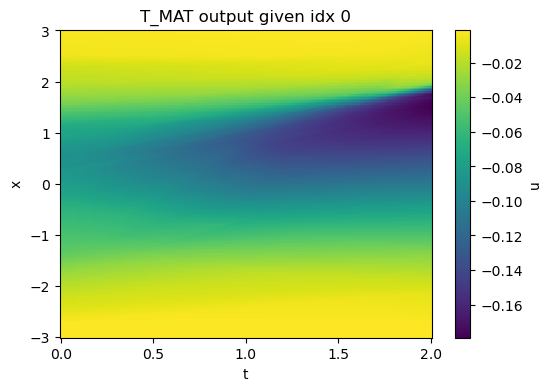

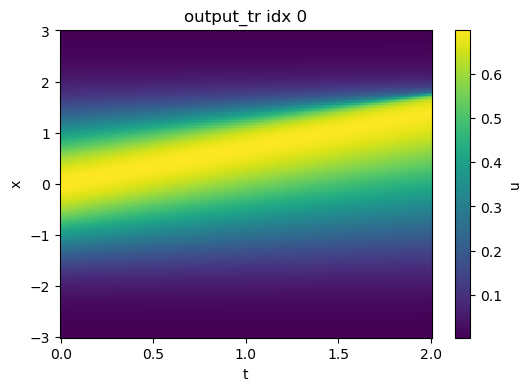

In [13]:

print(T.shape, X.shape, T_MAT[:,:,0].shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, T_MAT[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("T_MAT output given idx 0")
plt.colorbar(label="u")
plt.show()

plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, output_tr[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("output_tr idx 0")
plt.colorbar(label="u")
plt.show()



In [14]:
# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R = scipy.linalg.qr(T_MAT[i], mode = 'economic')
    # Q = scipy.linalg.lstsq(R.T,T_MAT_dense[i].T)[0].T
    # for j in range(0,Q.shape[1]):
    #     if jnp.mean((Q[j-1,:] - Q[j:] ) ** 2) >= jnp.mean((Q[j-1,:] + Q[j,:] ) ** 2):
    #         Q[j,:] = -1 * Q[j,:]
    #         R[:,j] = -1 * R[:,j]

    if i == 0:
        Q_MAT = Q[jnp.newaxis, :, :] # make the 3 tensor
        R_MAT = R[jnp.newaxis,:, :]
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis, :, :]], axis = 0) # stack Q_MAT in first dimension
        R_MAT = jnp.concatenate([R_MAT, R[jnp.newaxis, :, :]], axis = 0)
    
print(f"Q_MAT is of shape (t,x,n) = {Q_MAT.shape}")
print(f"R_MAT is of shape {R_MAT.shape}")
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

Q_MAT is of shape (t,x,n) = (201, 201, 10)
R_MAT is of shape (201, 10, 10)
shapes agree? True


## svd of data and solns

In [15]:
sv_tol = 1e-4 # what we are considering as singular
# output_tr is t,x,n
data_rank_hist = []

for i,t in enumerate(t_grid):
    data_at_t = output_tr[i, :, :]
    _, data_S, _ = scipy.linalg.svd(data_at_t)
    rank_at_t = jnp.sum(data_S > sv_tol)
    data_rank_hist.append(rank_at_t)

Text(0, 0.5, 'rank')

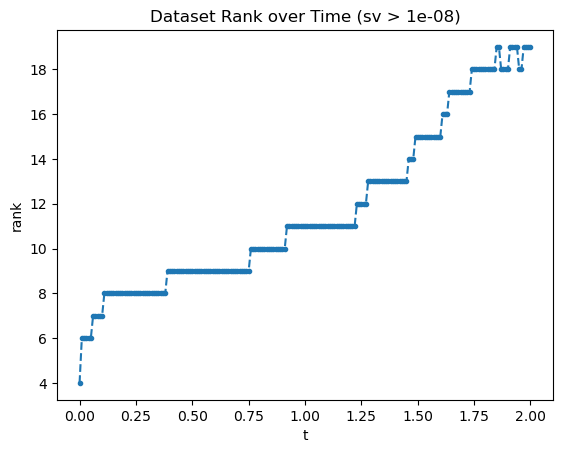

In [16]:
plt.plot(t_grid, data_rank_hist, '.--')
plt.title(f"Dataset Rank over Time (sv > {eps})")
plt.xlabel("t")
plt.ylabel("rank")


In [17]:
# plt.plot(t_grid, soln_rank_hist)
# plt.title(f"Rank over Time of Q[1] (sv > {eps})")
# plt.xlabel("t")
# plt.ylabel("rank")

In [18]:
_,R_last = scipy.linalg.qr(T_MAT[-1], mode = 'economic')

## 3d renders

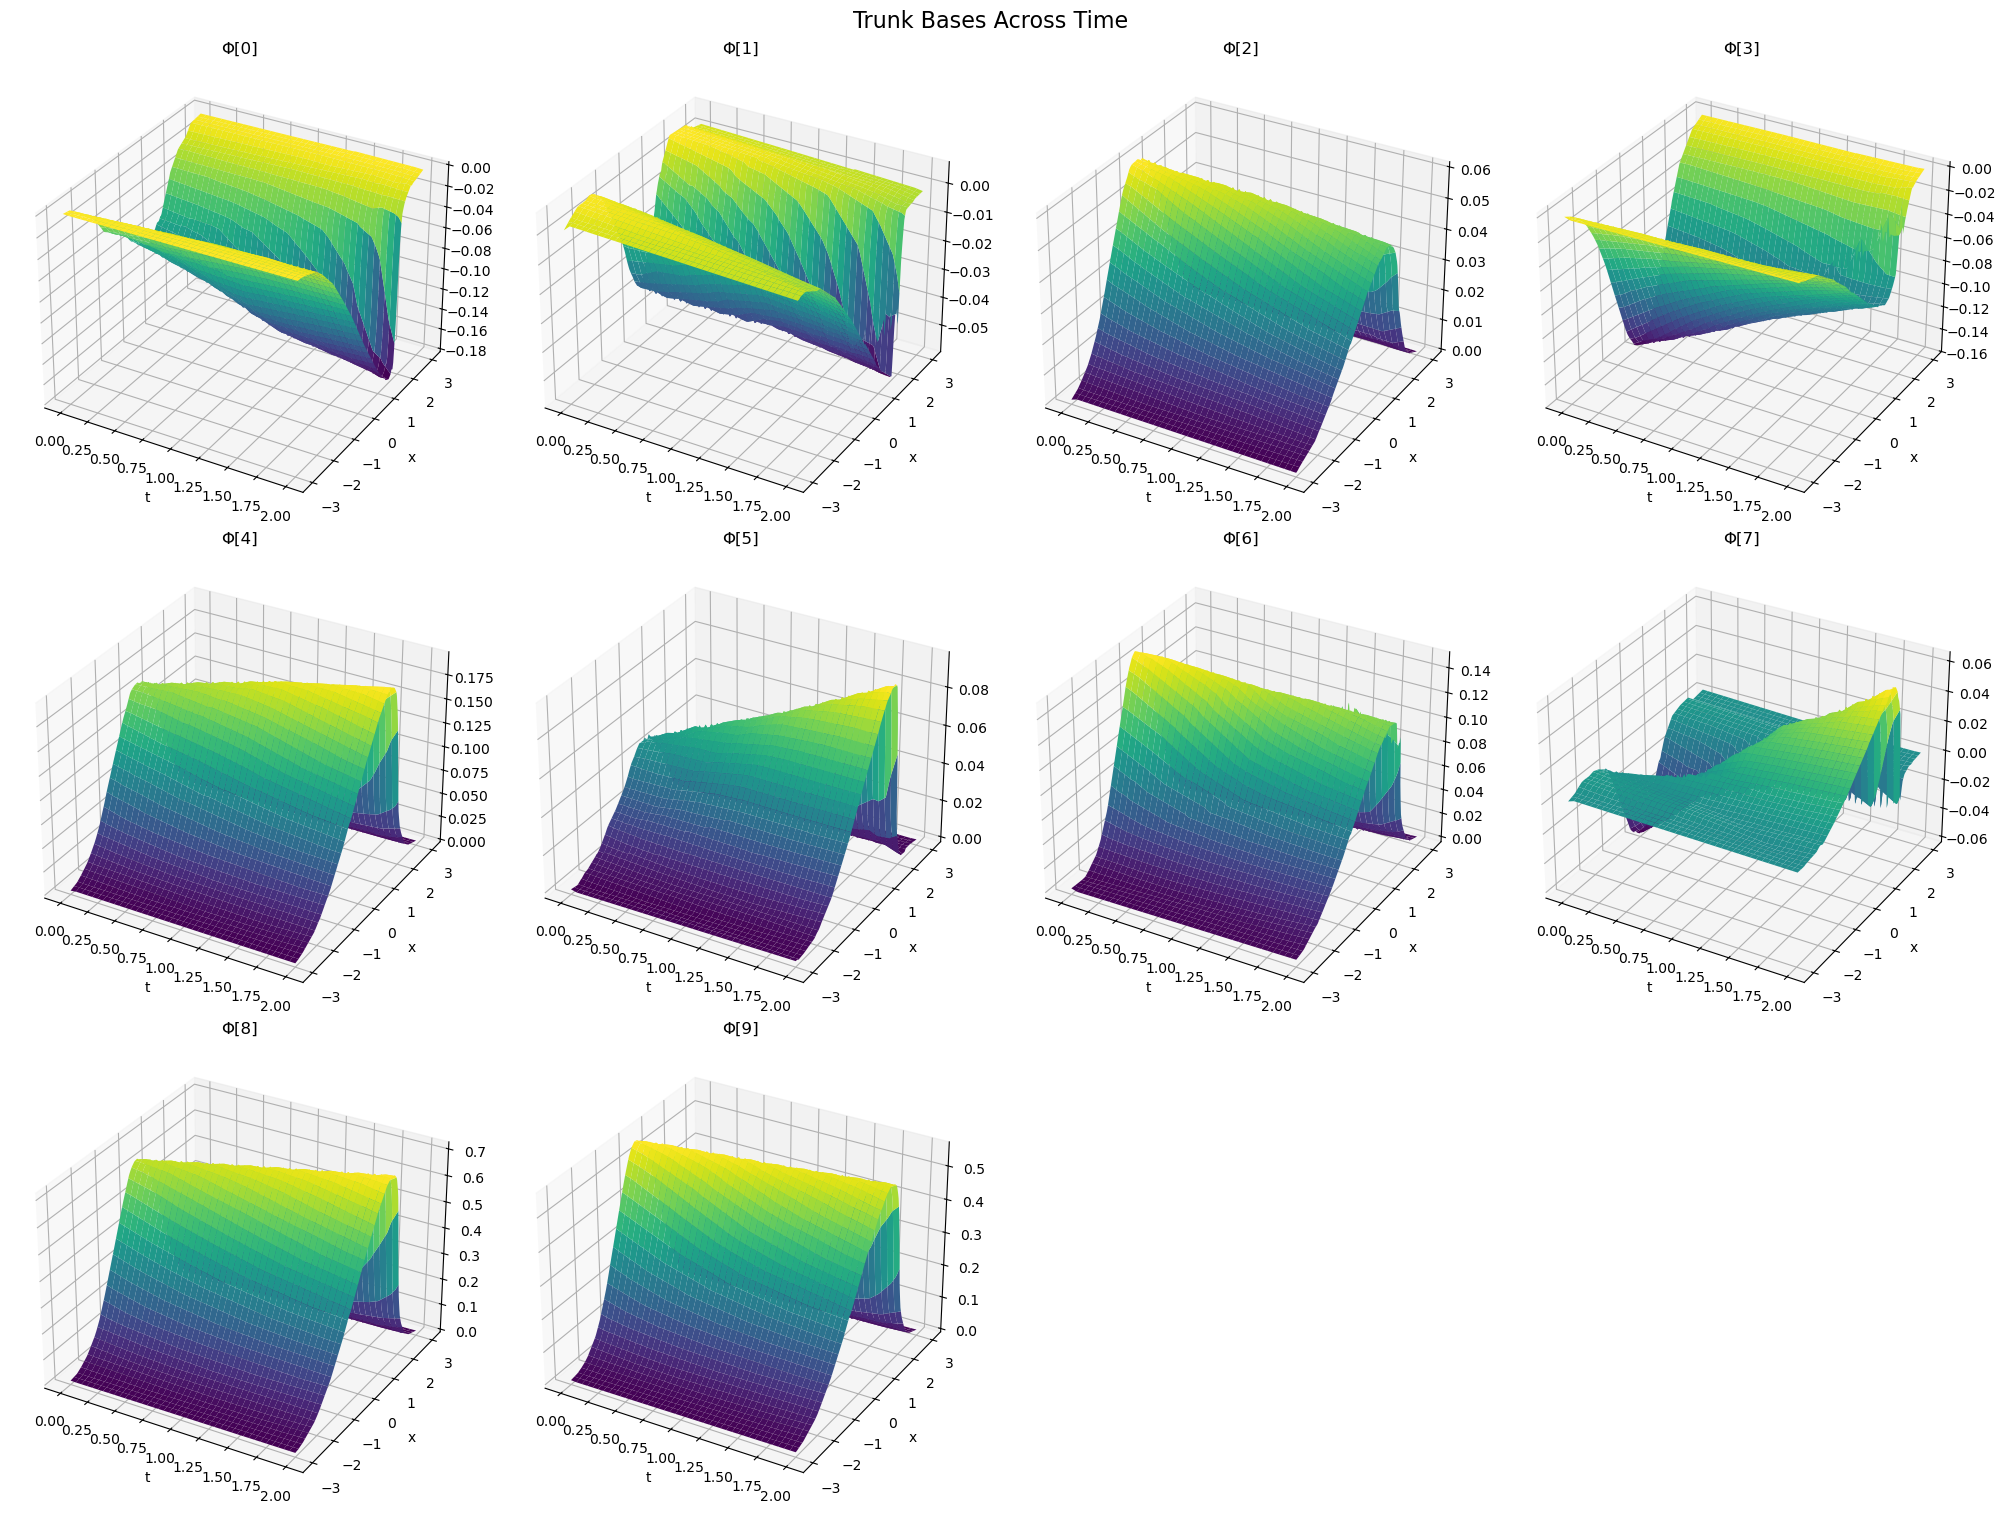

In [19]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid, x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        B_k = T_MAT[:,:,k]
        im = ax.plot_surface(T,X,B_k, cmap = 'viridis')
        ax.set_title(f"Φ[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Trunk Bases Across Time", fontsize=16)
plt.show()

(201, 201) (201, 201) (201, 201)


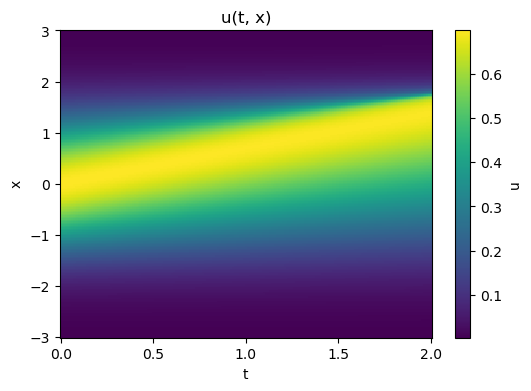

In [20]:

print(T.shape, X.shape, output_tr[:,:,0].shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, output_tr[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("u(t, x)")
plt.colorbar(label="u")
plt.show()


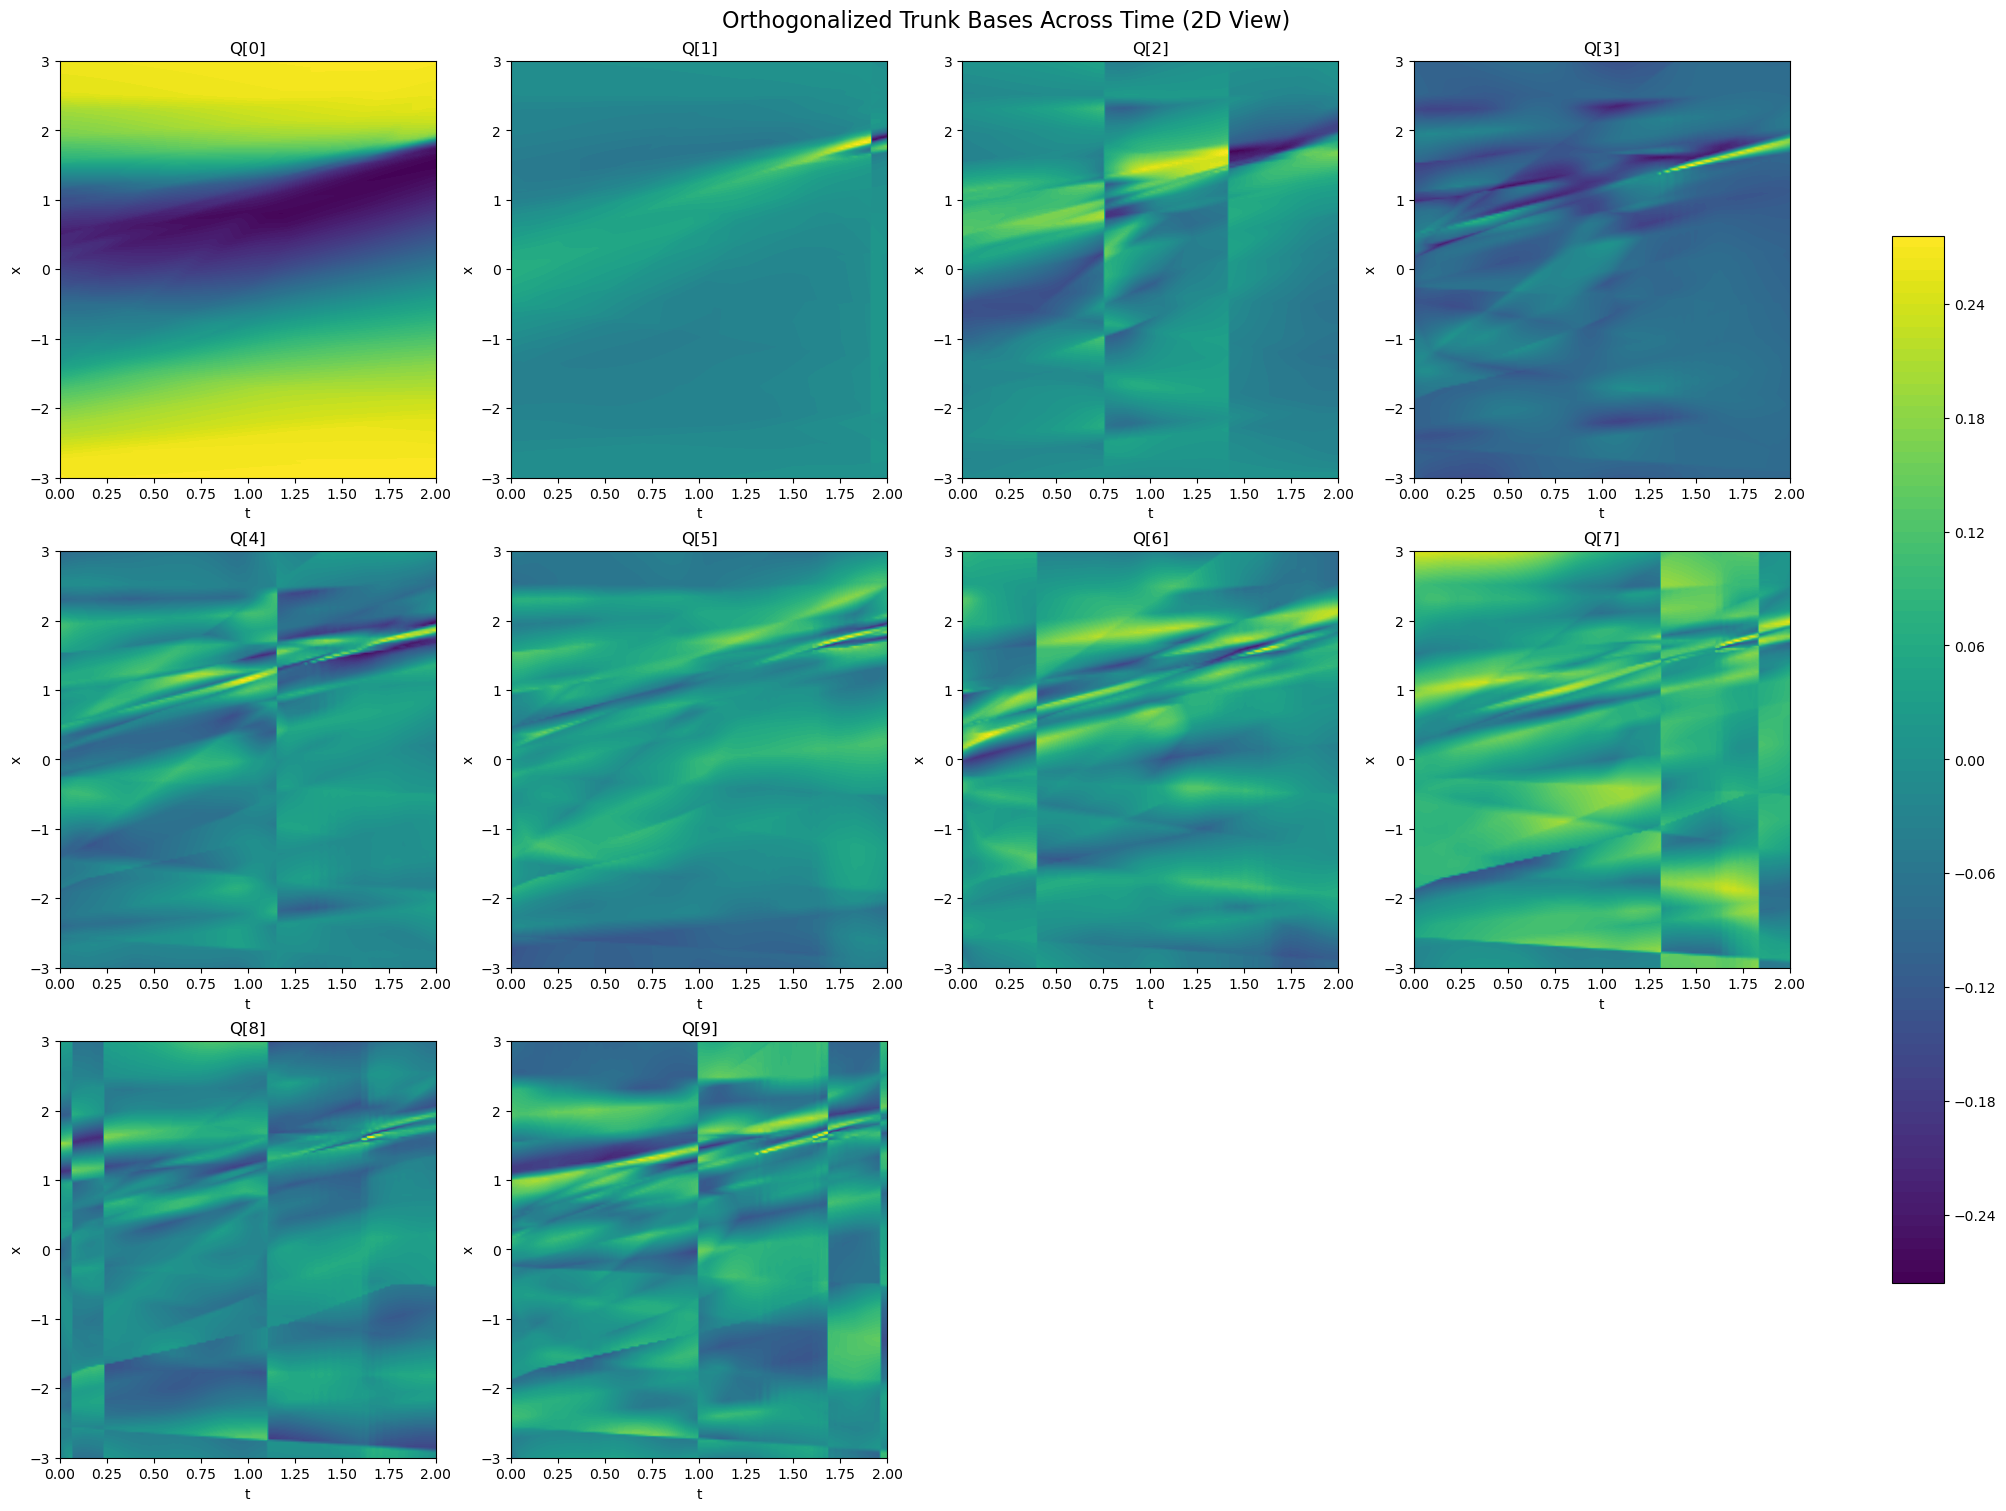

In [21]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    constrained_layout=True
)

axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:, :, k]

        # 2D top-down plot
        im = ax.contourf(T, X, Q_k, levels=100, cmap='viridis')

        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(
    f"Orthogonalized Trunk Bases Across Time (2D View)",
    fontsize=16
)

# attach a single colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.75)

plt.show()


In [22]:
Q_sign = np.array(Q_MAT, copy = True) #make np.array copies of tensors of QR factors
R_sign = np.array(R_MAT, copy = True)

# account for nonuniqueness in QR algorithm -- pick the closest Q columns by sign to ensure Q factors are time continuous
T = Q_sign.shape[0]
n = Q_sign.shape[2]

for k in range(1, T):          # time
    for j in range(n):         # basis index
        # choose sign to match previous time, just based on the first column
        if np.dot(Q_sign[k-1, :, j], Q_sign[k, :, j]) < 0:
            Q_sign[k, :, j] *= -1      # flip basis column of Q
            R_sign[k, j, :] *= -1      # flip corresponding row of R

# check for induced error on QR
for k in range(T):
    print(np.linalg.norm(Q_sign[k] @ R_sign[k] - T_MAT[k]))


9.3799997e-07
1.1005558e-06
2.5578063e-06
3.845935e-06
5.6896897e-06
1.0806425e-06
3.0869546e-06
1.0220742e-06
1.3562981e-06
1.369699e-06
5.306098e-06
1.7015967e-06
2.1530766e-06
1.4054217e-06
9.714186e-07
1.2580794e-06
7.9238254e-07
2.4946937e-06
3.5772994e-06
1.1401919e-06
4.0922605e-06
1.9278305e-06
1.3018106e-06
1.1228597e-06
1.6343913e-06
1.0759625e-06
1.9615911e-06
2.815841e-06
3.2775451e-06
2.833142e-06
8.9472064e-07
1.430626e-06
2.2684817e-06
1.0907754e-06
1.6908725e-06
3.1308082e-06
8.0109487e-07
2.7091733e-06
1.6905616e-06
2.124265e-06
2.1895366e-06
1.1739135e-06
3.5969952e-06
4.4234744e-06
3.7540906e-06
1.5392044e-06
1.4837395e-06
1.8231652e-06
1.2796223e-06
1.7251145e-06
1.6544332e-06
3.871249e-06
3.1105537e-06
8.8805587e-07
7.990816e-07
7.684334e-07
1.3481119e-06
2.1916699e-06
2.1695976e-06
2.9721014e-06
1.2524486e-06
1.9402037e-06
6.534185e-06
7.0066844e-06
3.0275164e-06
8.670028e-07
1.1781055e-06
2.1046067e-06
6.938752e-07
2.3769628e-06
1.6936746e-06
1.7541945e-06
7.2857

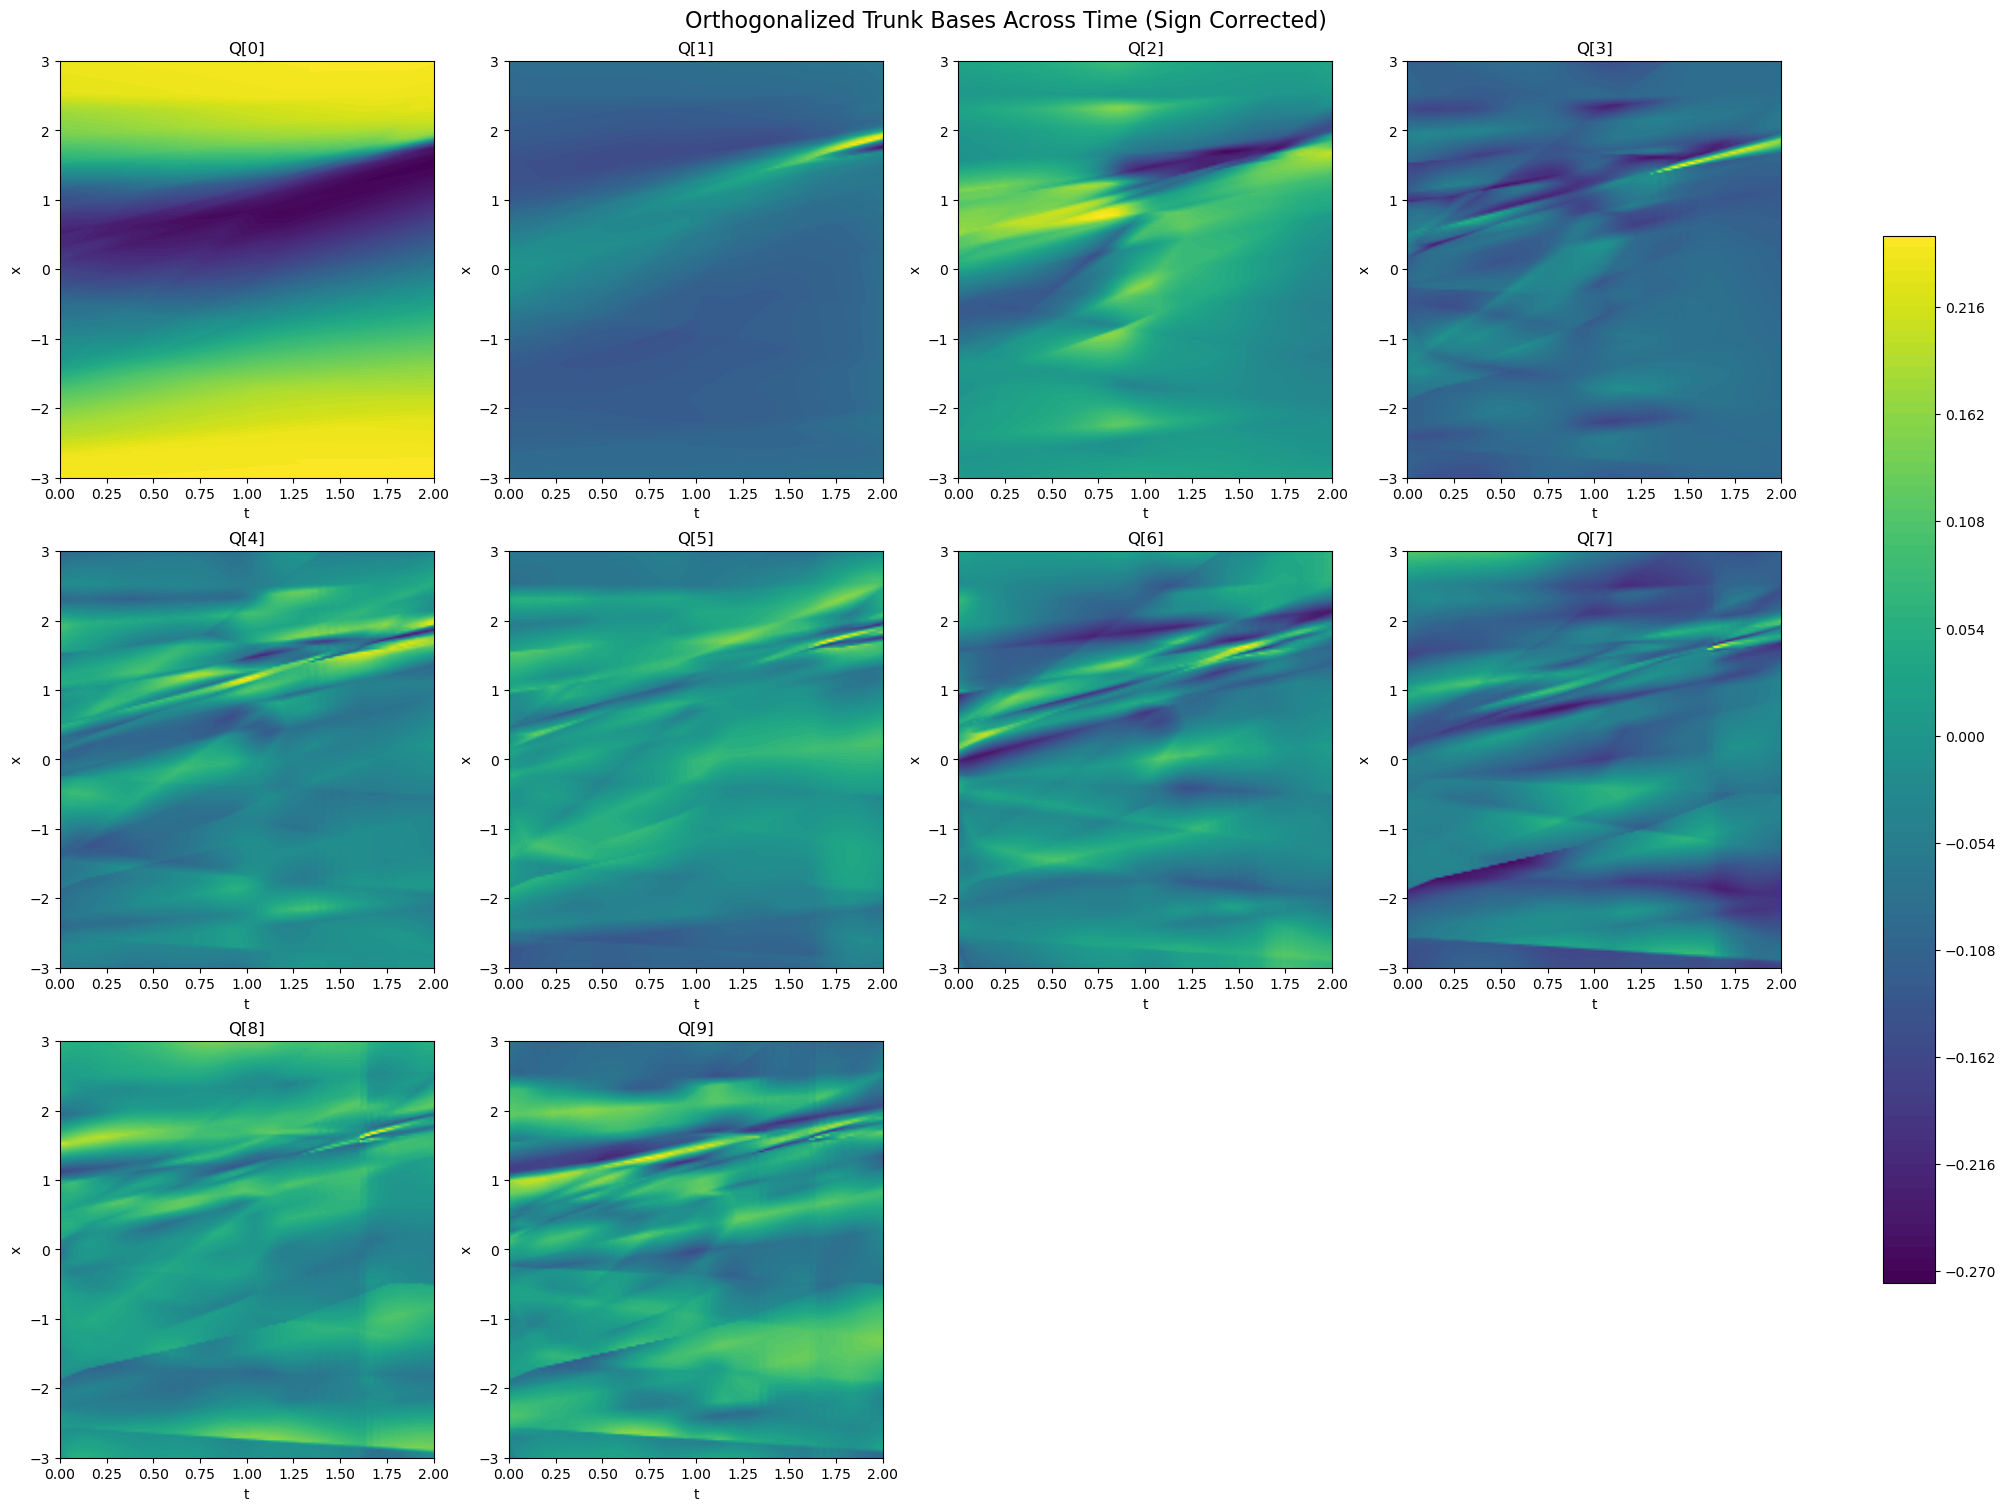

In [23]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    constrained_layout=True
)

axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_sign[:, :, k]

        # 2D top-down plot
        im = ax.contourf(T, X, Q_k, levels=100, cmap='viridis')

        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(
    f"Orthogonalized Trunk Bases Across Time (Sign Corrected)",
    fontsize=16
)

# attach a single colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.75)

plt.show()


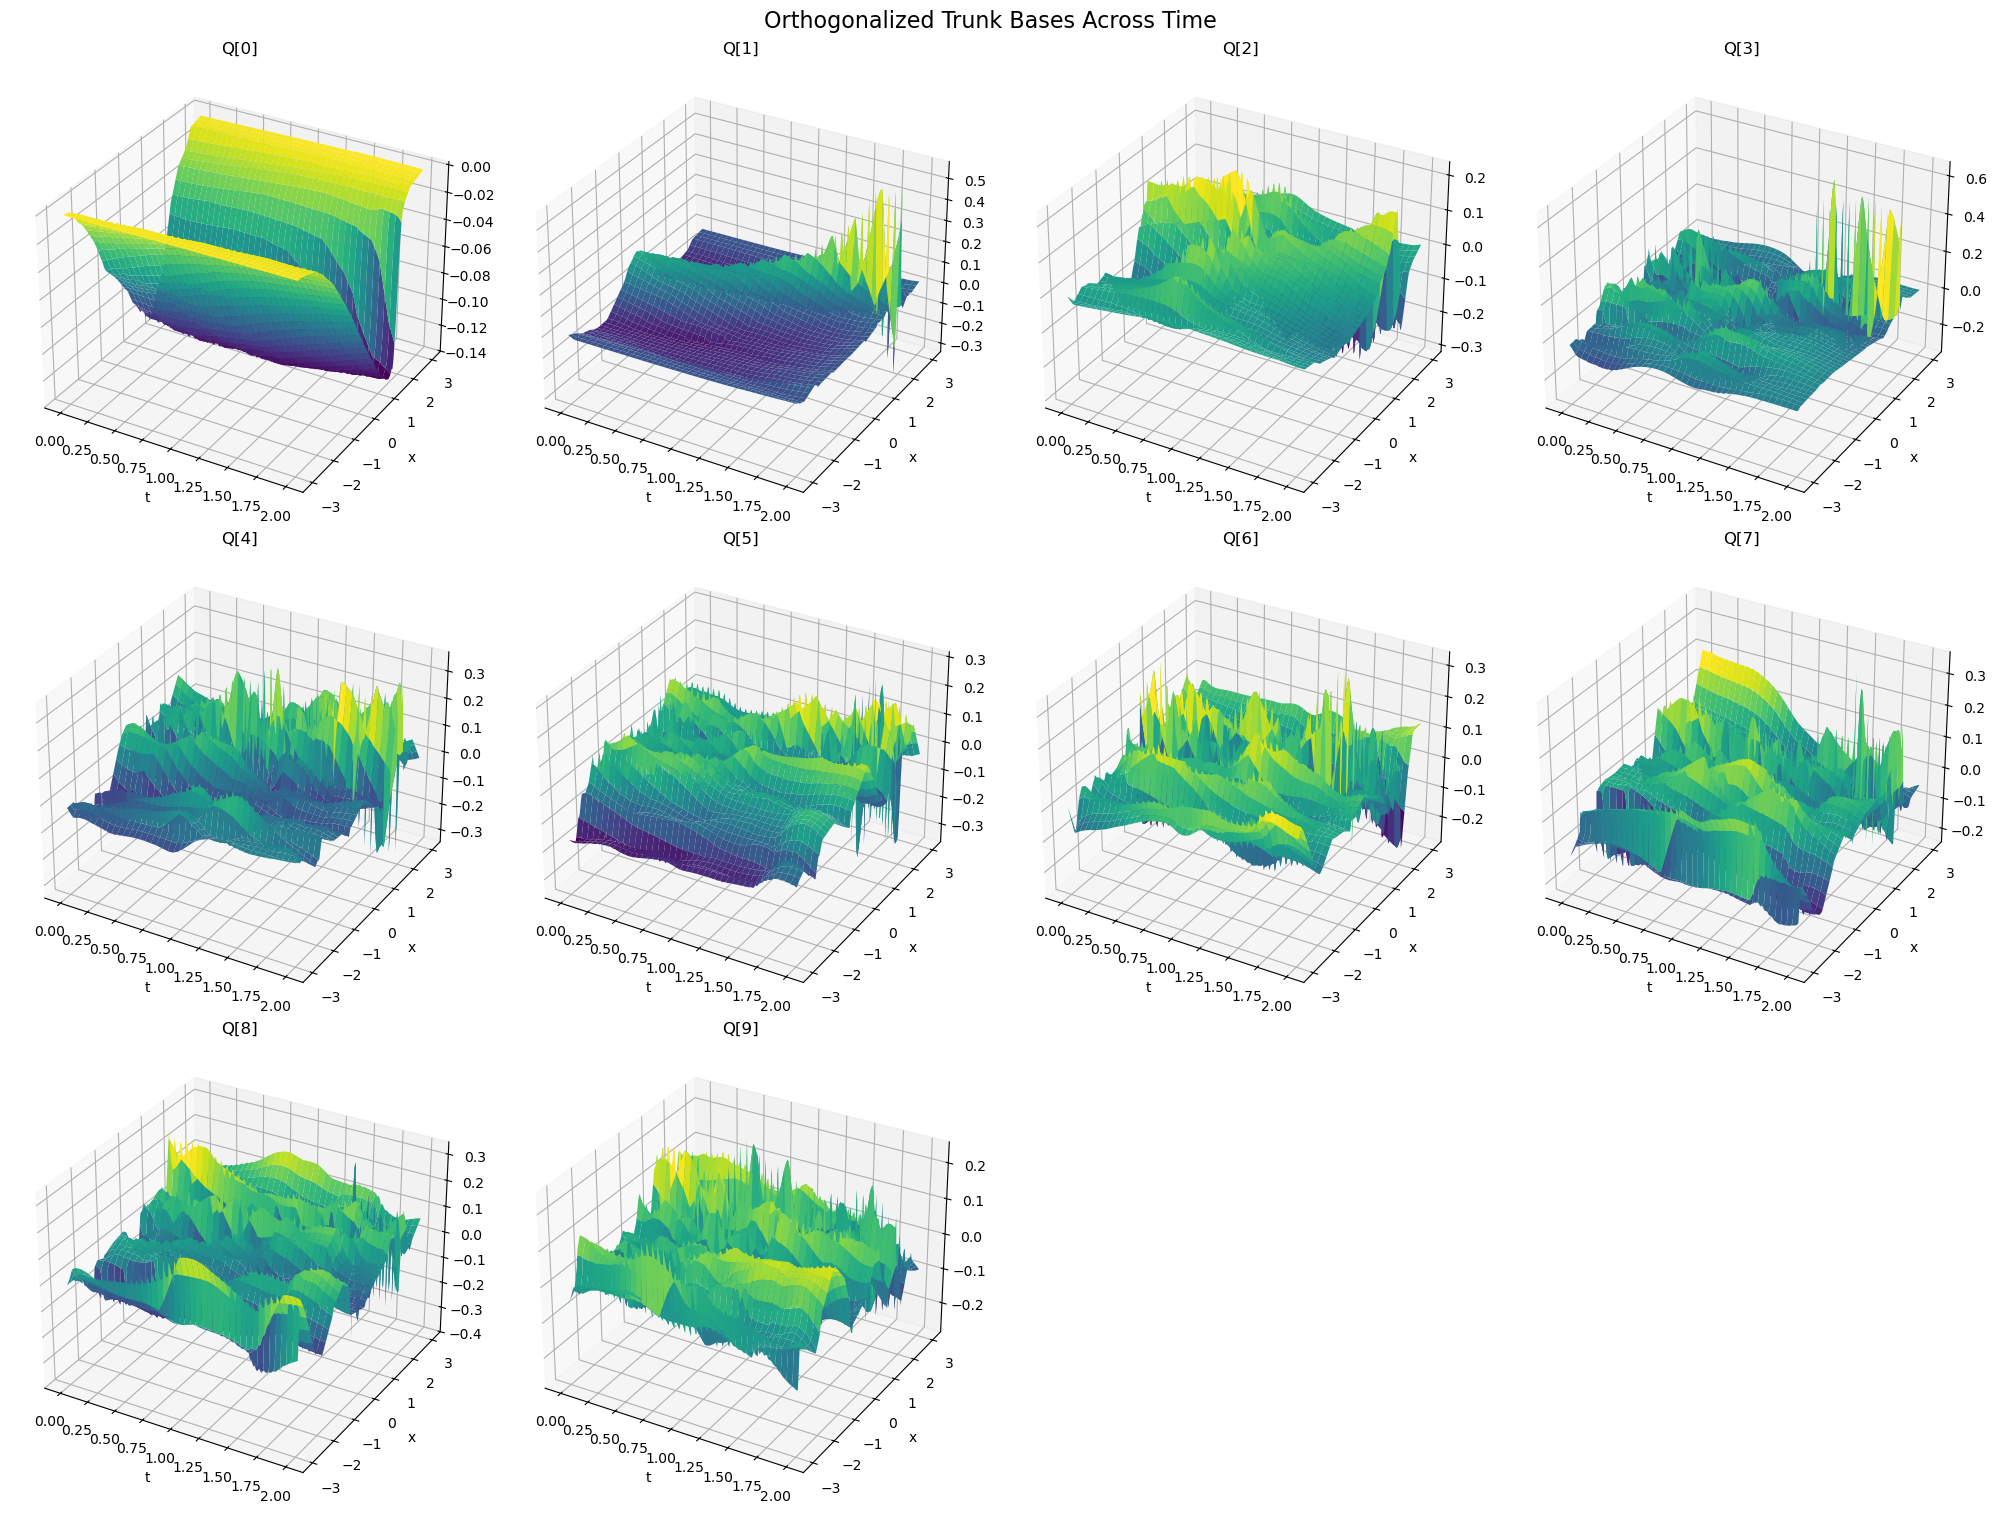

In [24]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid, x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_sign[:,:,k]
        im = ax.plot_surface(T,X,Q_k, cmap = 'viridis')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Orthogonalized Trunk Bases Across Time", fontsize=16)
plt.show()

## save out Q,R factors and data

In [25]:
save_path = Path("qr_factors_cont.npz")

# export data to .npz arrays
np.savez_compressed(
    save_path,
    Q = np.asarray(Q_sign),
    R = np.asarray(R_sign),
    t_grid = np.asarray(t_grid),
    x_grid = np.asarray(x_grid)
)

print("exported to:", save_path)

exported to: qr_factors_cont.npz


## .gif renders

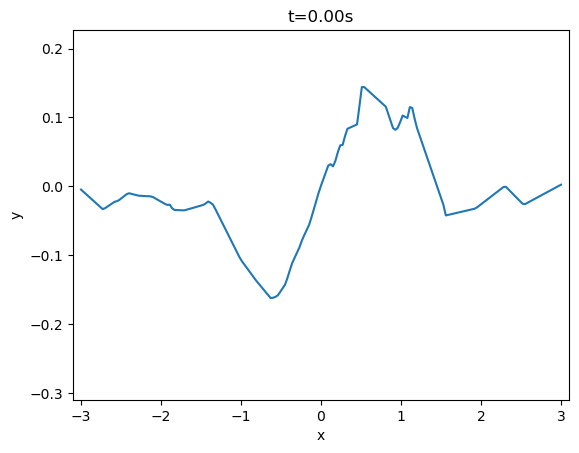

In [26]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

basis_idx = 2
fig, ax = plt.subplots()
line2 = ax.plot(x_grid,Q_sign[0,:,basis_idx])[0]
vmin, vmax = jnp.min(Q_sign[:,:,basis_idx]), jnp.max(Q_sign[:,:,basis_idx])
ax.set(xlim=[-3.1, 3.1], ylim=[vmin, vmax], xlabel='x', ylabel='y')
# ax.legend()

def update(frame):
    line2.set_xdata(x_grid)
    line2.set_ydata(Q_sign[frame,:,basis_idx])
    # update the title:
    ax.set_title(f't={t_grid[frame]:.2f}s')
    return line2

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(t_grid) -1 , interval=50)
ani.save(filename=f"DON_basis_{basis_idx}.gif", writer="pillow")

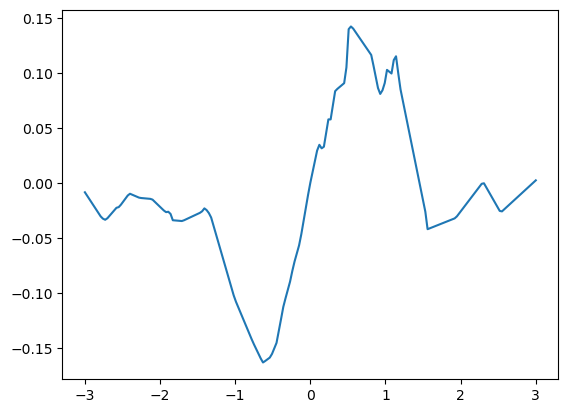

In [27]:
plt.plot(x_grid,Q_MAT[1,:,2])[0]

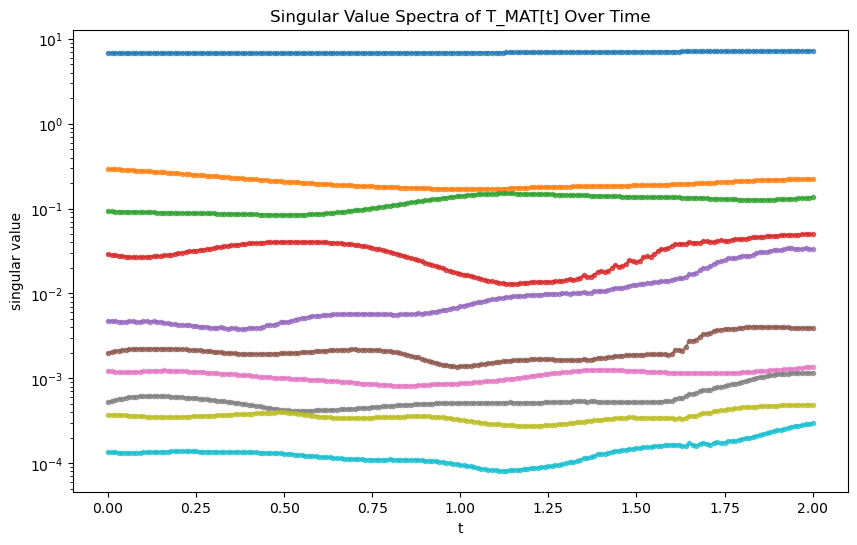

In [28]:
num_times = T_MAT.shape[0]

# compute SVD spectra at all times
sv_list = []
for i in range(num_times):
    _, S, _ = scipy.linalg.svd(np.array(T_MAT[i]), full_matrices=False)
    sv_list.append(S)

sv_array = np.vstack(sv_list)   # shape (t, num_bases)

plt.figure(figsize=(10,6))

for k in range(sv_array.shape[1]):
    plt.plot(t_grid, sv_array[:, k], '.-', alpha=0.7)

plt.yscale('log')
plt.xlabel("t")
plt.ylabel("singular value")
plt.title("Singular Value Spectra of T_MAT[t] Over Time")
#plt.grid(True, which='both', ls='--', alpha=0.3)

plt.show()

In [29]:
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
print(T_MAT.shape, A_model.shape)
pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model)

(201, 201, 10) (201, 10, 441)


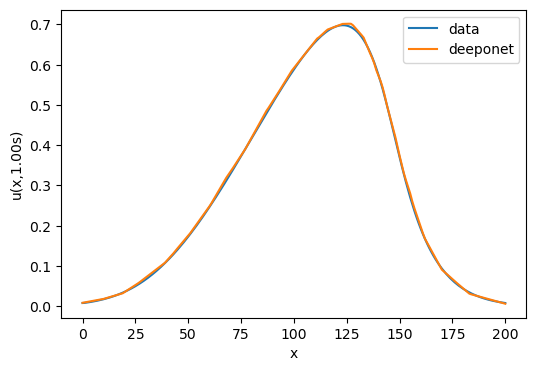

In [30]:
j= 100
idx_param = 20
# print(T.shape, X.shape, pred_y[:,:,0] - output_tr[:,:,0])
plt.figure(figsize=(6,4))
plt.plot(output_tr[j,:,idx_param], label='data')
plt.plot(pred_y[j,:,idx_param], label='deeponet')
plt.xlabel("x")
plt.ylabel(f"u(x,{t_grid[j]:.2f}s)")
plt.legend()
# plt.title("u(t, x)")
# plt.colorbar(label="u")
plt.show()
